In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os
import seaborn as sns
sns.set()

**Read data and transform them to pandas dataframe**

In [49]:
df = pd.read_csv("nyse/prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df.head()

,symbol,open,low,high,volume,adj close
date,,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


In [50]:
df2 = pd.read_csv("nyse/fundamentals.csv")
df2.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


**Extract all symbols from the list**

In [51]:
symbols = list(set(df.symbol))
len(symbols)

501

In [52]:
symbols[:11]

['TSCO', 'NOV', 'DVA', 'QRVO', 'FB', 'LUK', 'CAG', 'ECL', 'MA', 'SJM', 'TWX']

In [53]:
df = df[df.symbol == 'GOOG']
df.drop(['symbol'],1,inplace=True)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,312.304948,310.955001,313.580158,3927000.0,312.205308
2010-01-05,312.419511,309.610028,312.748278,6031900.0,310.830459
2010-01-06,311.761979,302.048370,311.761979,7987100.0,302.994813
2010-01-07,303.562685,295.218951,303.861575,12876600.0,295.941242
2010-01-08,294.895159,293.455551,300.499172,9483900.0,299.886470


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1762 entries, 2010-01-04 to 2016-12-30
Data columns (total 5 columns):
open         1762 non-null float64
low          1762 non-null float64
high         1762 non-null float64
volume       1762 non-null float64
adj close    1762 non-null float64
dtypes: float64(5)
memory usage: 82.6+ KB


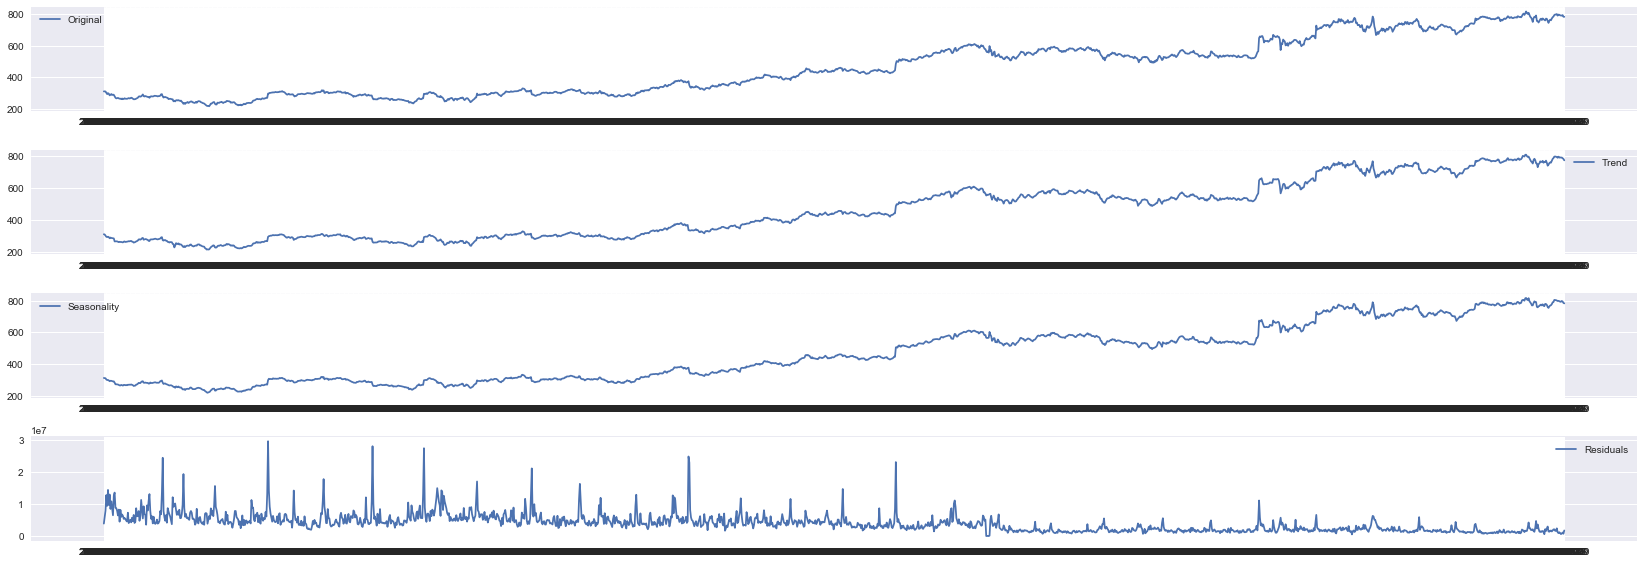

In [56]:
df.plot(figsize=(23,8),title = "Google Stock Price Analysis")
plt.subplot(411)
plt.plot(df.open, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(df.low, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(df.high,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(df.volume, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**Normalize the data**

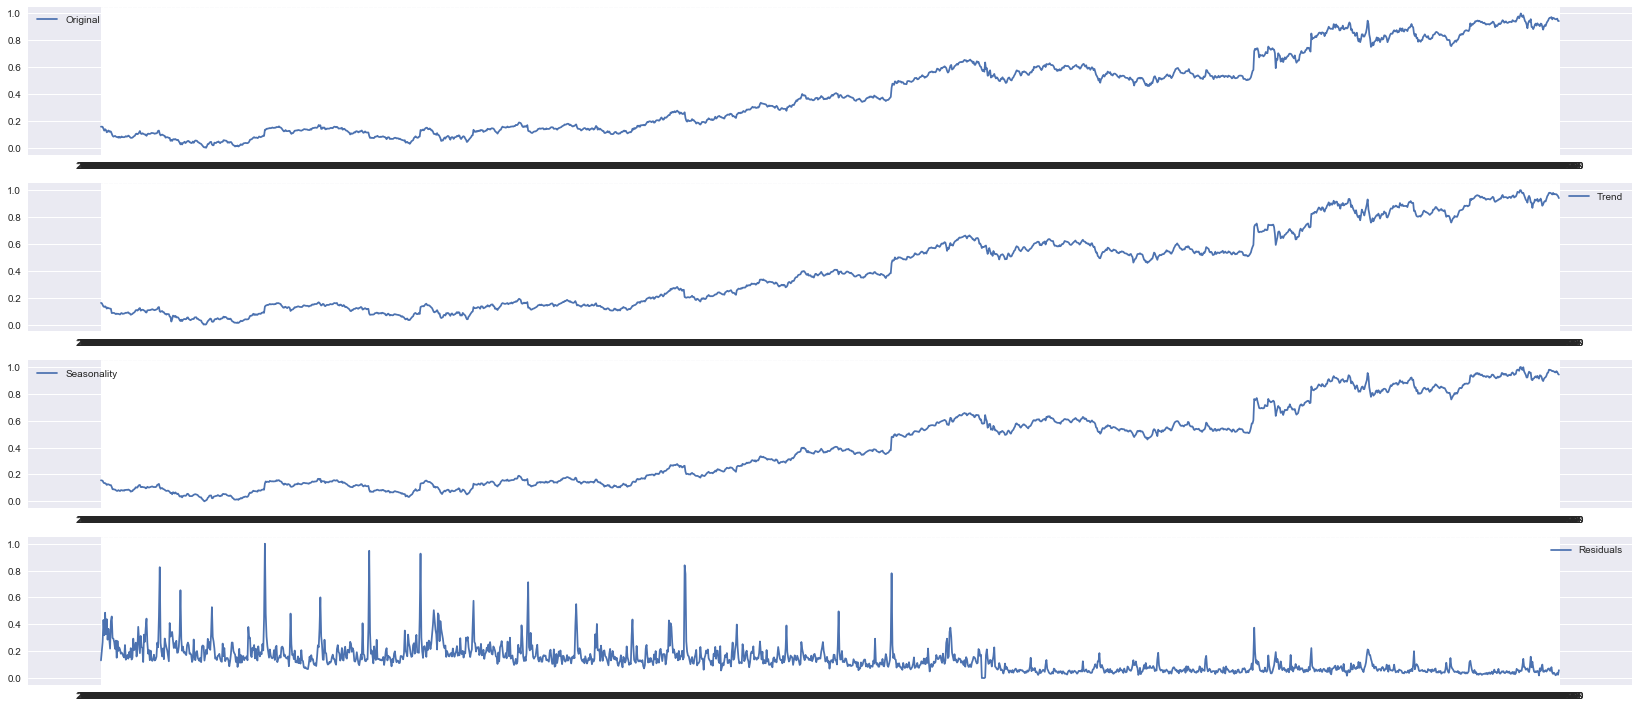

In [47]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.plot(figsize=(23,10))
plt.show()
plt.subplot(411)
plt.plot(df.open, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(df.low, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(df.high,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(df.volume, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**Create Training Set and Testing Set**

In [9]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

**Build the structure of model**  

* **dropout** = 0.3  
* **epochs** = 90  
* **LSTM** 256  
* LSTM 256 > Relu 32 > Linear 1

In [57]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

### Train Model

In [11]:
window = 22
X_train, y_train, X_test, y_test = load_data(df, window)
print (X_train[0], y_train[0])

[[0.15704696 0.16116746 0.15638998 0.1317225  0.15939908]
 [0.15723843 0.15888449 0.15499506 0.20246902 0.15709185]
 [0.15613951 0.14604929 0.15334121 0.26818406 0.14394234]
 [0.14243617 0.13445699 0.14009362 0.43252209 0.13210528]
 [0.12795029 0.13146379 0.13445546 0.3184921  0.13872603]
 [0.13832355 0.1356323  0.13546617 0.48640628 0.1379653 ]
 [0.13265404 0.13052526 0.13020388 0.3271972  0.12907917]
 [0.11503787 0.1186032  0.12203482 0.43807453 0.12624527]
 [0.12120685 0.12613696 0.12689613 0.2858228  0.12855249]
 [0.12906589 0.12210374 0.12636158 0.36641044 0.12031836]
 [0.11895908 0.12062405 0.12373877 0.29099208 0.12668832]
 [0.12293853 0.11977851 0.12003013 0.21906583 0.12066114]
 [0.12082392 0.1172081  0.12073176 0.42532947 0.1228095 ]
 [0.10505596 0.0855935  0.10718348 0.45857351 0.09524822]
 [0.09014547 0.08614311 0.08987641 0.29795279 0.08688037]
 [0.08296912 0.08680264 0.08964255 0.29361033 0.08890336]
 [0.08571648 0.08597403 0.08801372 0.26721945 0.08863587]
 [0.08839717 0

In [12]:
model = build_model([5,window,1])

Compilation Time :  0.03211355209350586


In [20]:
model.fit(X_train,y_train,batch_size=2048,epochs=50,validation_split=0.1,verbose=1)

Train on 1408 samples, validate on 157 samples
Epoch 1/50
1408/1408 [==============================] - 3s 2ms/step - loss: 9.9183e-04 - acc: 7.1023e-04 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 2/50
1408/1408 [==============================] - 3s 2ms/step - loss: 0.0011 - acc: 7.1023e-04 - val_loss: 0.0078 - val_acc: 0.0000e+00
Epoch 3/50
1408/1408 [==============================] - 3s 2ms/step - loss: 0.0010 - acc: 7.1023e-04 - val_loss: 0.0082 - val_acc: 0.0000e+00
Epoch 4/50
1408/1408 [==============================] - 3s 2ms/step - loss: 0.0010 - acc: 7.1023e-04 - val_loss: 0.0076 - val_acc: 0.0000e+00
Epoch 5/50
1408/1408 [==============================] - 4s 3ms/step - loss: 9.8577e-04 - acc: 7.1023e-04 - val_loss: 0.0065 - val_acc: 0.0000e+00
Epoch 6/50
1408/1408 [==============================] - 3s 2ms/step - loss: 0.0010 - acc: 7.1023e-04 - val_loss: 0.0061 - val_acc: 0.0000e+00
Epoch 7/50
1408/1408 [==============================] - 3s 2ms/step - loss: 9.6095e-04 - acc:

In [21]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
print (p.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    # print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
    # Last day prediction
    # print(p[-1]) 

(174, 1)


**Denormalize the data**

In [22]:
df = pd.read_csv("nyse/prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df = df[df.symbol == 'GOOG']
df.drop(['symbol'],1,inplace=True)

# Bug fixed at here, please update the denormalize function to this one
def denormalize(df, normalized_value): 
    df = df['adj close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, p)
newy_test = denormalize(df, y_test)

In [23]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00107 MSE (0.03 RMSE)
Test Score: 0.00791 MSE (0.09 RMSE)


(0.001071222130054483, 0.007908337535443663)

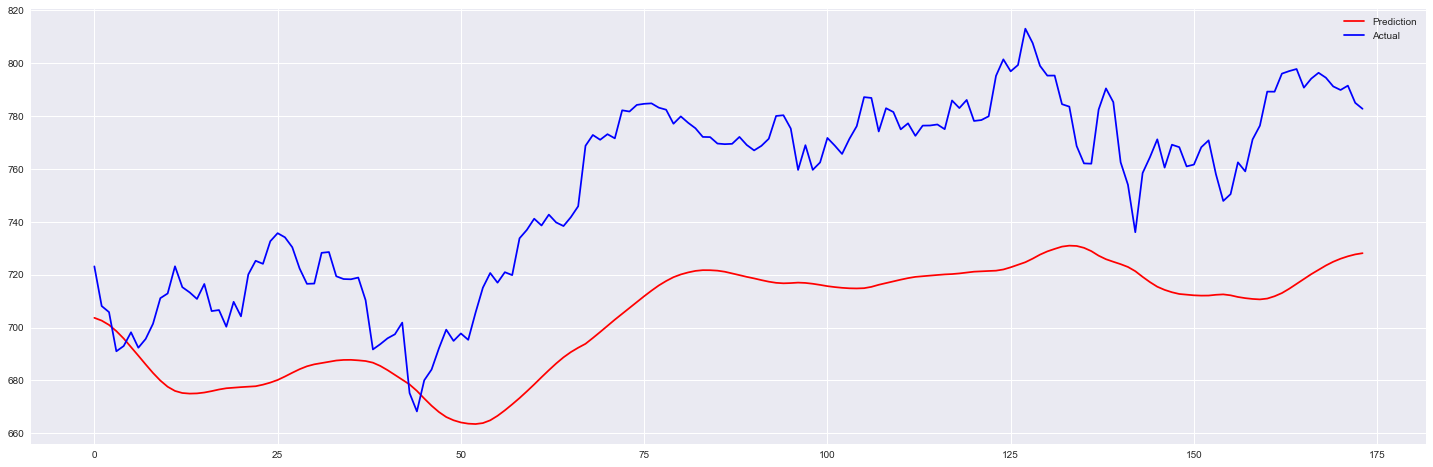

In [24]:
import matplotlib.pyplot as plt2
plt.figure(figsize=(25,8))
plt2.plot(newp,color='red', label='Prediction')
plt2.plot(newy_test,color='blue', label='Actual')
plt2.legend(loc='best')
plt2.show()